In [72]:
import gymnasium as gym
import grid2op
from grid2op import gym_compat
from grid2op.Parameters import Parameters
from grid2op.Action import PlayableAction
from grid2op.Observation import CompleteObservation
from grid2op.Reward import L2RPNReward, N1Reward, CombinedScaledReward

from lightsim2grid import LightSimBackend
import numpy as np
from gymnasium.spaces import Box, Discrete

import matplotlib.pyplot as plt
from stable_baselines3 import DQN

In [73]:
import grid2op
print(grid2op.__version__)

1.10.5


- #### `Initialise` the environment

In [76]:
class Gym2OpEnv(gym.Env):
    def __init__(self):
        super().__init__()

        self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox"  # DO NOT CHANGE

        action_class = PlayableAction
        observation_class = CompleteObservation
        reward_class = CombinedScaledReward
     

        # DO NOT CHANGE Parameters
        p = Parameters()
        p.MAX_SUB_CHANGED = 4
        p.MAX_LINE_STATUS_CHANGED = 4

        # Make grid2op env
        self._g2op_env = grid2op.make(
            self._env_name,
            backend=self._backend,
            test=False,
            action_class=action_class,
            observation_class=observation_class,
            reward_class=reward_class,
            param=p,
         )

        # Set combined reward
        cr = self._g2op_env.get_reward_instance()
        cr.addReward("N1", N1Reward(), 1.0)
        cr.addReward("L2RPN", L2RPNReward(), 1.0)
        cr.initialize(self._g2op_env)
        self._g2op_env.change_reward(cr)

        self._gym_env = gym_compat.GymEnv(self._g2op_env)

        self.setup_observations()
        self.setup_actions()

    def setup_observations(self):
        # Flatten the observation space
        sample_obs, _ = self._gym_env.reset()
        flat_obs = self.flatten_observation(sample_obs)
        obs_size = flat_obs.shape[0]
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(obs_size,), dtype=np.float32)

    def setup_actions(self):
        self.available_actions = []

        # Get the action space from the Grid2Op environment
        action_space = self._g2op_env.action_space

        # Define discrete actions
        # Action 0: Do nothing
        no_op = action_space({})
        gym_no_op = self._gym_env.action_space.to_gym(no_op)
        self.available_actions.append(gym_no_op)

        # Action 1: Open line 0
        open_line_0 = action_space({"set_line_status": [(0, -1)]})
        gym_open_line_0 = self._gym_env.action_space.to_gym(open_line_0)
        self.available_actions.append(gym_open_line_0)

        # Action 2: Close line 0
        close_line_0 = action_space({"set_line_status": [(0, 1)]})
        gym_close_line_0 = self._gym_env.action_space.to_gym(close_line_0)
        self.available_actions.append(gym_close_line_0)

        # Add more actions as needed
        # For example, open/close other lines

        # Update the action space to Discrete
        self.action_space = gym.spaces.Discrete(len(self.available_actions))

        # Print the action mappings
        print("Available actions:")
        for idx, action in enumerate(self.available_actions):
            print(f'action {idx}: {action}')

    def reset(self, seed=None):
        obs, info = self._gym_env.reset(seed=seed, options=None)
        obs = self.flatten_observation(obs)
        return obs, info

    def step(self, action):
        # Retrieve the Gym-formatted action
        gym_action = self.available_actions[action]

        # Pass the action to the environment
        obs, reward, terminated, truncated, info = self._gym_env.step(gym_action)
        obs = self.flatten_observation(obs)

        # Extract individual rewards
        reward_components = info.get('reward_detail', {})
        info['reward_components'] = reward_components
        
        return obs, reward, terminated, truncated, info

    def render(self):
        return self._gym_env.render()

    def flatten_observation(self, obs):
        obs_list = []
        for key in sorted(obs.keys()):
            obs_component = np.array(obs[key]).flatten()
            obs_list.append(obs_component)
        flat_obs = np.concatenate(obs_list).astype(np.float32)
        return flat_obs

- #### `Test` the environment

In [77]:
def test_environment():
    env = Gym2OpEnv()
    obs, info = env.reset()
    print("Initial observation shape:", obs.shape)
    print("Initial observation:", obs)

    for _ in range(5):
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        print("Step result:")
        print("Action taken:", action)
        print("Observation shape:", obs.shape)
        print("Reward:", reward)
        print("Terminated:", terminated)
        if terminated or truncated:
            obs, info = env.reset()

if __name__ == "__main__":
    test_environment()

Available actions:
action 0: OrderedDict([('change_bus', array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])), ('change_line_status', array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])), ('curtail', array([-1., -1., -1., -1., -1., -1.], dtype=float32)), ('redispatch', array([0., 0., 0., 0., 0., 0.], dtype=float32)), ('set_bus', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 

AttributeError: 'Environment_l2rpn_case14_sandbox' object has no attribute 'reward_helper'

-  #### `Print` observation space and action space

In [53]:
def test_environment():
    env = Gym2OpEnv()

    # Print the action and observation spaces
    print("Action space:", env.action_space)
    print("Number of actions:", env.action_space.n)
    print("Observation space:", env.observation_space)
    print("Observation shape:", env.observation_space.shape)

    obs, info = env.reset()
    print("Initial observation shape:", obs.shape)
    print("Initial observation:", obs)

    # Sample a random action
    action = env.action_space.sample()
    print("Sampled action index:", action)
    print("Corresponding action:", env.available_actions[action])

    # Take a step
    obs, reward, terminated, truncated, info = env.step(action)
    print("Observation after action:", obs)
    print("Reward received:", reward)
    print("Terminated:", terminated)
    print("Truncated:", truncated)
    print("Info:", info)

In [54]:
test_environment()

Available actions:
action 0: OrderedDict([('change_bus', array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])), ('change_line_status', array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])), ('curtail', array([-1., -1., -1., -1., -1., -1.], dtype=float32)), ('redispatch', array([0., 0., 0., 0., 0., 0.], dtype=float32)), ('set_bus', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 

- #### `Test` the environment

In [55]:
def main():
    max_steps = 100
    env = Gym2OpEnv()

    print("#####################")
    print("# OBSERVATION SPACE #")
    print("#####################")
    print(env.observation_space)
    print("#####################\n")

    print("#####################")
    print("#   ACTION SPACE    #")
    print("#####################")
    print(env.action_space)
    print("#####################\n\n")

    curr_step = 0
    curr_return = 0

    is_done = False
    obs, info = env.reset()
    print(f"step = {curr_step} (reset):")
    print(f"\t obs = {obs}")
    print(f"\t info = {info}\n\n")

    while not is_done and curr_step < max_steps:
        # Random action
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)

        curr_step += 1
        curr_return += reward
        is_done = terminated or truncated

        print(f"step = {curr_step}: ")
        print(f"\t obs = {obs}")
        print(f"\t reward = {reward}")
        print(f"\t terminated = {terminated}")
        print(f"\t truncated = {truncated}")
        print(f"\t info = {info}")

        # Checking if action is valid
        is_action_valid = not (info["is_illegal"] or info["is_ambiguous"])
        print(f"\t is action valid = {is_action_valid}")
        if not is_action_valid:
            print(f"\t\t reason = {info['exception']}")
        print("\n")

    print("###########")
    print("# SUMMARY #")
    print("###########")
    print(f"return = {curr_return}")
    print(f"total steps = {curr_step}")
    print("###########")

if __name__ == "__main__":
    main()

Available actions:
action 0: OrderedDict([('change_bus', array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])), ('change_line_status', array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])), ('curtail', array([-1., -1., -1., -1., -1., -1.], dtype=float32)), ('redispatch', array([0., 0., 0., 0., 0., 0.], dtype=float32)), ('set_bus', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 

# Implement your agent here

Available actions:
action 0: OrderedDict([('change_bus', array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])), ('change_line_status', array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])), ('curtail', array([-1., -1., -1., -1., -1., -1.], dtype=float32)), ('redispatch', array([0., 0., 0., 0., 0., 0.], dtype=float32)), ('set_bus', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 

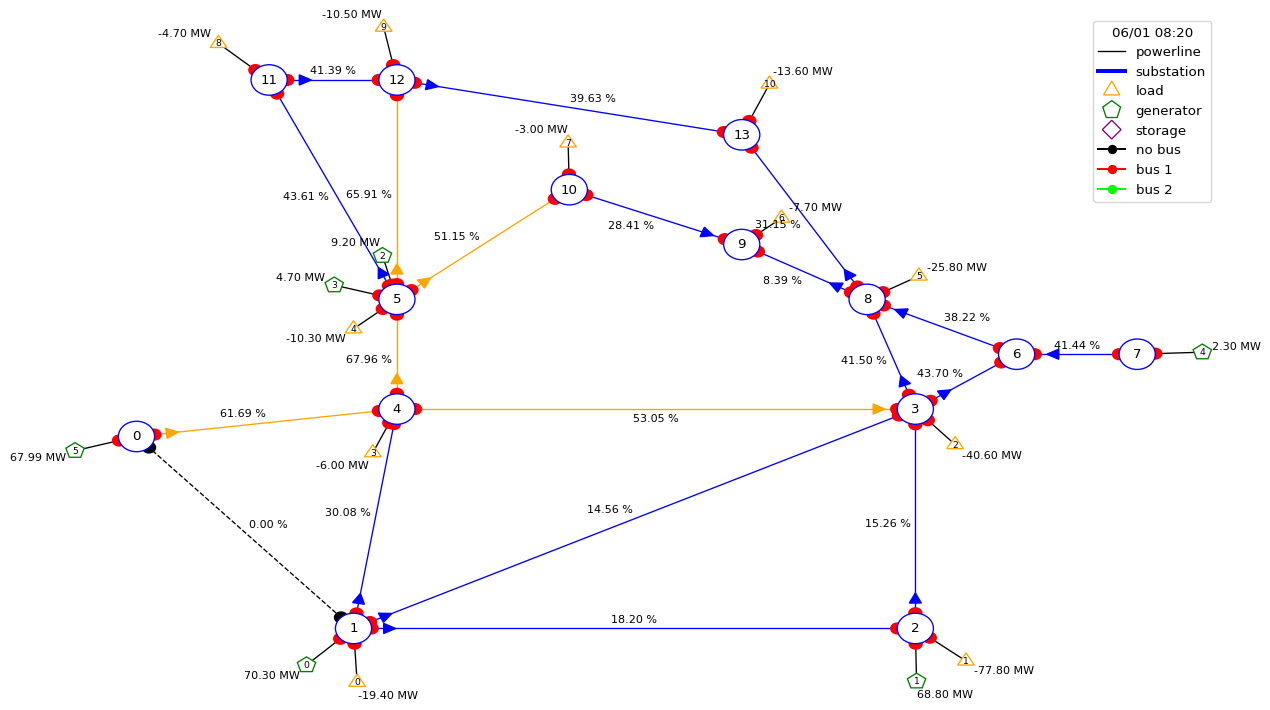

In [56]:
def train_dqn_agent():
    env = Gym2OpEnv()
    model = DQN("MlpPolicy", env, verbose=1,
            learning_rate=0.0005,
            buffer_size=100000,
            batch_size=32,
            gamma=0.99,
            exploration_fraction=0.1,
            exploration_final_eps=0.02)
    model.learn(total_timesteps=10000)
    model.save("dqn_grid2op_agent")

    # Evaluate the trained model
    obs, _ = env.reset()
    for step in range(100):
        action, _states = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)
        env.render()
        if done:
            print("Episode finished after {} timesteps".format(step + 1))
            break

if __name__ == "__main__":
    train_dqn_agent()

- #### `Evaluate` the environment

In [57]:
def evaluate_agent(model, env, num_episodes=10):
    episode_rewards = []
    reward_sum = 0
    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, _, info = env.step(action)
            total_reward += reward
        episode_rewards.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
        reward_sum += total_reward
    print(f"Average Reward:", reward_sum/num_episodes)
    return episode_rewards

- #### `Run` the evaluation function

In [58]:
if __name__ == "__main__":
    # Initialize the environment and model
    env = Gym2OpEnv()
    model = DQN("MlpPolicy", env, verbose=1)
    
    # Train the model
    #model.learn(total_timesteps=10000)
    #model.save("dqn_grid2op_agent")
    
    # Load the trained model (optional)
    model = DQN.load("dqn_grid2op_agent", env=env)
    
    # Evaluate the trained model
    num_evaluation_episodes = 20
    rewards = evaluate_agent(model, env, num_episodes=num_evaluation_episodes)

Available actions:
action 0: OrderedDict([('change_bus', array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])), ('change_line_status', array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])), ('curtail', array([-1., -1., -1., -1., -1., -1.], dtype=float32)), ('redispatch', array([0., 0., 0., 0., 0., 0.], dtype=float32)), ('set_bus', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 

- #### `Visualise` the results



In [59]:
def plot_rewards(episode_rewards):
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(episode_rewards) + 1), episode_rewards, marker='o')
    plt.title('Agent Performance Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()


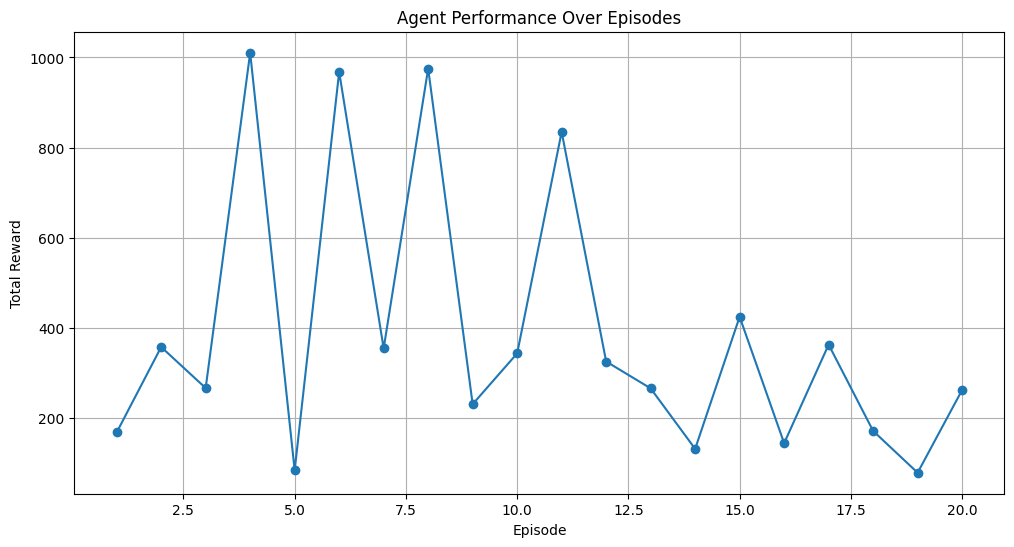

In [60]:
# call plot function
plot_rewards(rewards)

- #### `Extracting` individual reward components (L2RPN & N1)

In [63]:
def evaluate_agent(model, env, num_episodes=10):
    episode_rewards = []
    reward_components_list = []
    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        episode_reward_components = {'L2RPN': 0.0, 'N1': 0.0}
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, _, info = env.step(action)
            total_reward += reward

            # Print the info dictionary
            #print(f"Step info: {info}")

            # Accumulate reward components
            reward_components = info.get('rewards_components', {})
            for key in episode_reward_components.keys():
                episode_reward_components[key] += reward_components.get(key, 0.0)
        episode_rewards.append(total_reward)
        reward_components_list.append(episode_reward_components)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
        print(f"Reward Components: {episode_reward_components}")
        
    return episode_rewards, reward_components_list

In [64]:
# Call the Evaluate agent function
rewards, reward_components_list = evaluate_agent(model, env, num_episodes=num_evaluation_episodes)

Episode 1: Total Reward = 885.1985947787762
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}


KeyboardInterrupt: 

- #### `Visualising` individual reward components (L2RPN & N1)

In [38]:
# def plot_reward_components(reward_components_list):
#     episodes = range(1, len(reward_components_list) + 1)
#     l2rpn_rewards = [rc['L2RPN'] for rc in reward_components_list]
#     n1_rewards = [rc['N1'] for rc in reward_components_list]
    
#     plt.figure(figsize=(12, 6))
#     plt.plot(episodes, l2rpn_rewards, label='L2RPN Reward', marker='o')
#     plt.plot(episodes, n1_rewards, label='N1 Reward', marker='s')
#     plt.title('Reward Components Over Episodes')
#     plt.xlabel('Episode')
#     plt.ylabel('Reward')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

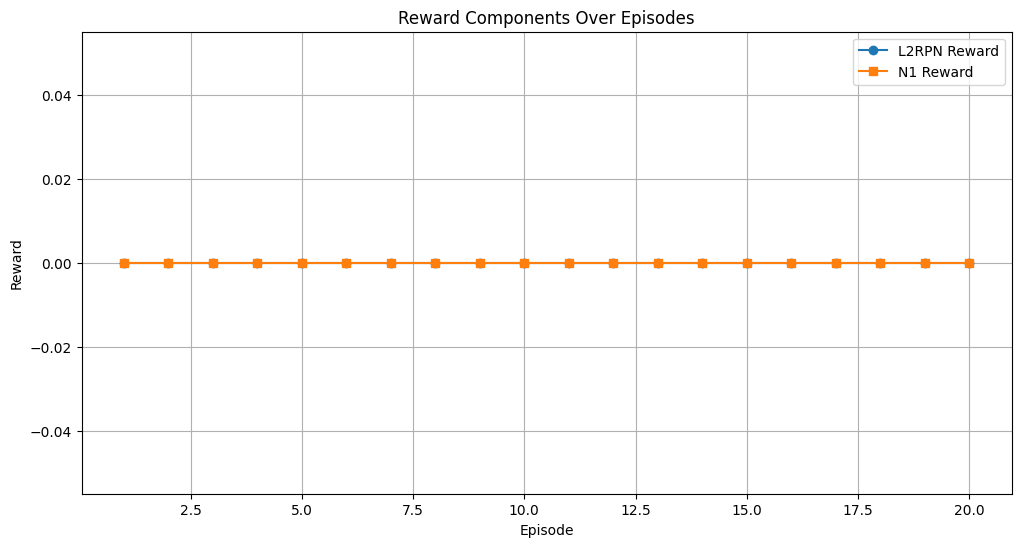

In [39]:
# # Call the plot_reward_components
# plot_reward_components(reward_components_list)